## Create function model of neural network

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

def get_model():
    # model.
    model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(10, activation='softmax')])
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

## Normalize the train and test data

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = X_train/255
X_test = X_test/255

## Train the model and save the model in HDF5 format

In [3]:
model = get_model()
model.fit(X_train, y_train, epochs=10)
model.save('sm1.h5')

2022-08-31 12:08:10.655948: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2659 - accuracy: 0.9224
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1147 - accuracy: 0.9650
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0815 - accuracy: 0.9748
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0621 - accuracy: 0.9805
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0502 - accuracy: 0.9840
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0406 - accuracy: 0.9872
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0343 - accuracy: 0.9889
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0289 - accuracy: 0.9904
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0243 - accuracy: 0.9922
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.021

## Load the saved HDF5 model to confirm and resave as tensorflow saved model

In [4]:
model = keras.models.load_model("sm1.h5")
tf.saved_model.save(model, "tmp_model")

INFO:tensorflow:Assets written to: tmp_model/assets


## Summary of the saved HDF5 model

In [13]:
from tensorflow.python.keras.models import load_model
model = load_model('sm1.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


## Convert the HDF5 model to .onnx format

In [5]:
!python3 -m tf2onnx.convert --saved-model tmp_model --output "sm1.onnx"

/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-08-31 12:11:42,400 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2022-08-31 12:11:42,599 - INFO - Signatures found in model: [serving_default].
2022-08-31 12:11:42,599 - WARNING - '--signature_def' not specified, using first signature: serving_default
2022-08-31 12:11:42,600 - INFO - Output names: ['dense_2']
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-08-31 12:11:42,643 - WARNING - From /Users/user02/Desktop/dlb/penv/lib/python3.8/site-packages/tf2onnx/tf_loader.py:711: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructi

## Load the onnx model for confirmation 

In [7]:
from google.protobuf.json_format import MessageToDict
import onnx

model = onnx.load("sm1.onnx")
for _input in model.graph.input:
    print(MessageToDict(_input))

{'name': 'flatten_input', 'type': {'tensorType': {'elemType': 1, 'shape': {'dim': [{'dimParam': 'unk__8'}, {'dimValue': '28'}, {'dimValue': '28'}]}}}}


In [11]:
# Confirm the input shape of the converted Onnx model
model = onnx.load("sm1.onnx")
input_shapes = [[d.dim_value for d in _input.type.tensor_type.shape.dim] for _input in model.graph.input]
print(input_shapes)

[[0, 28, 28]]


## Convert the onnx model to .nnoir format

In [12]:
!onnx2nnoir -o sm1.nnoir --fix_dimension unk__8=1 sm1.onnx

## Visual representation of the saved models

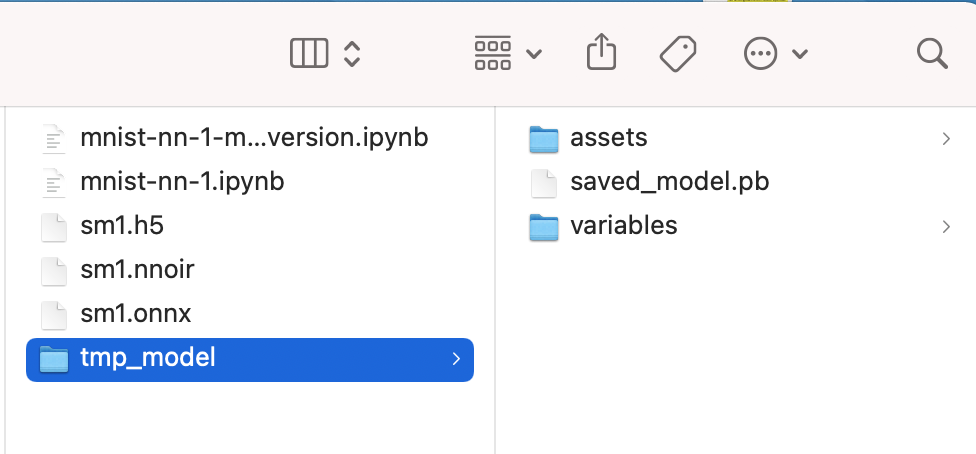